# **SSVEP Analysis: From Raw Data to Machine Learning Framework**

## **Overview**  
This notebook focuses on processing raw SSVEP data and identifying optimal filtering parameters based on Signal-to-Noise Ratio (SNR) analysis. The findings will serve as the foundation for developing a machine learning framework for the subesquent classification.

## **Objectives**  
1. **Load Raw EEG Data**: Import unfiltered EEG signals directly from a `.cnt` file.  
2. **Visual Analysis**: Examine temporal and spectral features of unfiltered data.  
3. **Frequency Analysis**: Compute SNR for differentr SSVEP stimulation frequencies to determine the filter parameter.  

Loading raw data from SSVEP01.cnt...
Reading 0 ... 391804  =      0.000 ...   391.804 secs...
Raw data loaded successfully!

Raw Data Info:
<Info | 10 non-empty values
 bads: 3 items (HEOR-L, VEOL-U, Trigger)
 ch_names: HEOL, HEOR-L, Fp1, Fp2, VEOU, VEOL-U, F7, F3, Fz, F4, F8, FT7, ...
 chs: 38 EEG
 custom_ref_applied: False
 dig: 41 items (3 Cardinal, 38 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2021-08-07 21:17:22 UTC
 nchan: 38
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | id: 0, sex: 0 (FIFFV_SUBJ_SEX_UNKNOWN), first_name: , last_name: >
>
Channel types adjusted for non-EEG channels.
Montage set for raw EEG data.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
EEG data re-referenced using A1 and A2.
Reference channels A1 and A2 dropped. Remaining channels:
['HEOL', 'HEOR-L', 'Fp1', 'Fp2', 'VEOU', 'VEOL-U', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', '

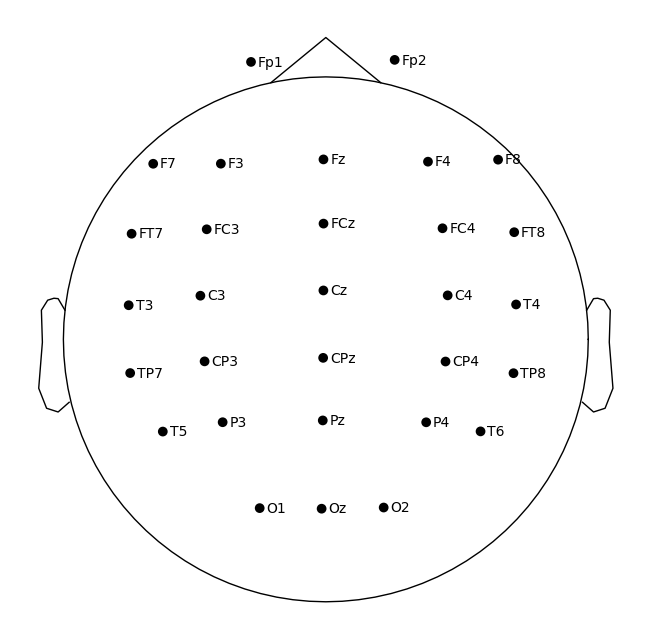

Sensor locations plotted successfully!


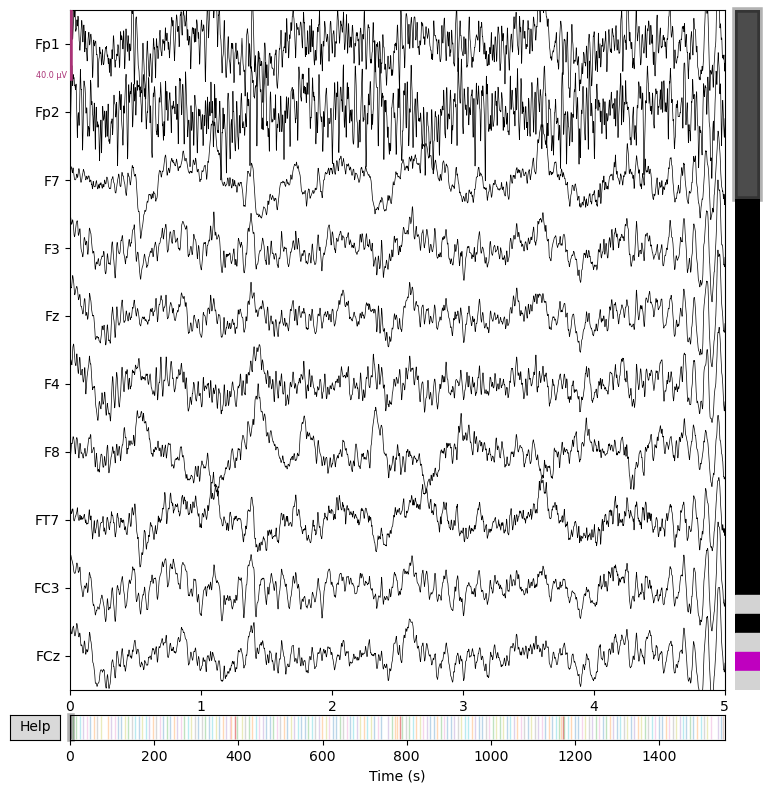

Raw data segment plotted successfully!
Used Annotations descriptions: ['1', '100', '2', '3', '36', '4', '5', '6', '7', '8', '9', '99']
Events extracted from annotations:
[[   6157       0      12]
 [  14675       0       3]
 [  22927       0       9]
 [  31263       0       4]
 [  39506       0       6]
 [  47829       0       1]
 [  56263       0      11]
 [  64694       0       7]
 [  72848       0       8]
 [  89327       0      11]
 [  97678       0       4]
 [ 105938       0       6]
 [ 114262       0       1]
 [ 122330       0      10]
 [ 130503       0       8]
 [ 138738       0       3]
 [ 147178       0       7]
 [ 155437       0       9]
 [ 163496       0      10]
 [ 171664       0       8]
 [ 179903       0       9]
 [ 188244       0       4]
 [ 196695       0      11]
 [ 205145       0       7]
 [ 213403       0       6]
 [ 221743       0       1]
 [ 230004       0       3]
 [ 238360       0       1]
 [ 246810       0      11]
 [ 255145       0       4]
 [ 263388       0   

In [9]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict
from scipy import signal

# Global dictionary for non-EEG channel types.
NON_EEG_CHANNELS = {
    'HEOL': 'eog',
    'HEOR-L': 'eog',
    'VEOU': 'eog',
    'VEOL-U': 'eog',
    'EKG': 'ecg',
    'Trigger': 'stim'
}

def load_and_preprocess_file(file_name: str) -> mne.io.Raw:
    """
    Load a CNT file and perform standard preprocessing:
      - Set channel types for non-EEG channels.
      - Apply a standard montage ('standard_1005').
      - Re-reference using A1 and A2, then drop these channels.
    """
    print(f"Loading raw data from {file_name}...")
    raw = mne.io.read_raw_cnt(file_name, preload=True)
    print("Raw data loaded successfully!")
    print("\nRaw Data Info:")
    print(raw.info)
    
    raw.set_channel_types(NON_EEG_CHANNELS)
    print("Channel types adjusted for non-EEG channels.")
    
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage, match_case=False, on_missing='ignore')
    print("Montage set for raw EEG data.")
    
    raw.set_eeg_reference(ref_channels=['A1', 'A2'], projection=False)
    print("EEG data re-referenced using A1 and A2.")
    
    raw.drop_channels(['A1', 'A2'])
    print("Reference channels A1 and A2 dropped. Remaining channels:")
    print(raw.info['ch_names'])
    
    return raw

def combine_raw_files(file_names: List[str]) -> mne.io.Raw:
    """
    Load and concatenate raw data from a list of CNT files.
    """
    raw_list = [load_and_preprocess_file(f) for f in file_names]
    # Force calibration factors (_cals) to match across files.
    common_cals = raw_list[0]._cals.copy()
    for raw in raw_list:
        raw._cals = common_cals
    raw_combined = mne.concatenate_raws(raw_list, preload=True)
    print("All files have been concatenated.")
    return raw_combined

def create_epochs_from_raw(raw: mne.io.Raw, tmin: float = 0.5, tmax: float = 4.5,
                           valid_keys: List[str] = None) -> mne.Epochs:
    """
    Extract events from the raw data and create epochs.
    
    Instead of hardcoding valid event codes, this function accepts an optional
    list of valid annotation keys (strings). If not provided, it defaults to
    including all keys except known non-stimulation ones (e.g. '100', '99').
    """
    events, event_id = mne.events_from_annotations(raw)
    print("Events extracted from annotations:")
    print(events)
    print("Event IDs mapping:")
    print(event_id)
    
    # If no valid_keys are provided, default to all keys except known non-stimulation ones (99 and 100).
    if valid_keys is None:
        valid_keys = [k for k in event_id.keys() if k not in ['100', '99']]
    # Build the list of valid event codes from the event_id dictionary.
    valid_codes = [event_id[k] for k in valid_keys if k in event_id]
    print("Using valid event codes:", valid_codes)
    
    trial_events = events[np.isin(events[:, 2], valid_codes)]
    print("Trial events:")
    print(trial_events)
    #     epochs = mne.Epochs(raw, events=trial_events, event_id=['1','2','3','4','5','6','7','8','9'], tmin=tmin, tmax=tmax,

    epochs = mne.Epochs(raw, events=None, event_id=valid_keys, tmin=tmin, tmax=tmax,
                        baseline=None, preload=True)
    print(f"Epochs created with {tmax - tmin} seconds duration for each trial.")
    
    channels_of_interest = ['O1', 'O2', 'Oz', 'Fz']
    epochs.pick_channels(channels_of_interest)
    print("Selected channels for analysis:", epochs.ch_names)
    
    return epochs

def get_channel_indices(epochs: mne.Epochs, channels: List[str]) -> Dict[str, int]:
    """
    Get the indices of specified channels in the EEG data.
    
    Parameters:
    - epochs (mne.Epochs): The EEG epochs containing channel information.
    - channels (List[str]): List of channel names to find indices for.
    
    Returns:
    - channel_indices (Dict[str, int]): Mapping of channel names to their indices.
    """
    channel_names = [name.upper() for name in epochs.info['ch_names']]
    channel_indices = {}
    for ch in channels:
        if ch.upper() in channel_names:
            channel_indices[ch] = channel_names.index(ch.upper())
        else:
            raise ValueError(f"Channel {ch} not found in data.")
    return channel_indices



# =============================================================================
# List of CNT file names.
file_names = ["SSVEP01.cnt", "SSVEP02.cnt", "SSVEP03.cnt", "SSVEP04.cnt"]

# Combine data from all files.
raw_combined = combine_raw_files(file_names)

# (Optional) Visualize sensor locations and a short data segment.
try:
    raw_combined.plot_sensors(show_names=True)
    print("Sensor locations plotted successfully!")
except Exception as e:
    print("Error plotting sensors:", e)
try:
    raw_combined.plot(start=0, duration=5, n_channels=10)
    print("Raw data segment plotted successfully!")
except Exception as e:
    print("Error plotting raw data:", e)
plt.show()

# Create epochs.
# Here, we let valid_keys default to all keys except '100' and '99'.
epochs = create_epochs_from_raw(raw_combined, tmin=0.4, tmax=4.4)

# Convert epochs data to a NumPy array and print its shape.
data = epochs.get_data()
print("Epochs data shape:", data.shape)

# Save event codes for each trial.
trial_event_codes = epochs.events[:, 2].tolist()
print("Trial event codes:", trial_event_codes)

## **Temporal and Spectral Analysis of SSVEP Data**

### **Temporal Profiles**
To evaluate the EEG response over time, we plot the **mean and standard deviation of EEG signals** for different stimulation frequencies for Oz and Fz channels. This analysis helps us observe how the signal evolves across trials and whether there are distinguishable periodic patterns.

- The temporal profiles show a **clear periodic pattern** that is more pronounced in the **Oz channel** compared to the Fz channel.  
- The **strongest periodic signals** appear for **8 Hz, 10 Hz, 12, and 14 Hz** stimulations.  
- The periodicity in Oz suggests **a robust brain response to visual flicker**, while Fz (a frontal electrode) shows much weaker responses.

### **Spectral Analysis**
To quantify the frequency-domain characteristics of the SSVEP response, we compute the **Power Spectral Density (PSD)** using the Welch method.

- The **PSD profile confirms the temporal observations**, showing dominant spectral peaks at **8 Hz, 10 Hz, 12, and 14 Hz**.
- These peaks indicate that these frequencies elicit the strongest **steady-state visual responses** in the subject.
- Vertical dashed lines mark the expected stimulation frequencies and their harmonics, further reinforcing the observed spectral peaks.

### **Implications for Machine Learning**
The clear dominance of **8 Hz, 10 Hz, and 12 Hz** in both the time and frequency domains provides a strong basis for **feature extraction** in an SSVEP-based classification model. This finding is in line with the previous literature. This means that using frequences between 8 and 14 Hz would be the most optimal for a real-world BCI implementation 


Using event mapping: {'1': '6 Hz', '2': '8 Hz', '3': '10 Hz', '4': '12 Hz', '5': 'No Stimulation', '6': '14 Hz', '7': '20 Hz', '8': '25 Hz', '9': '30 Hz'}


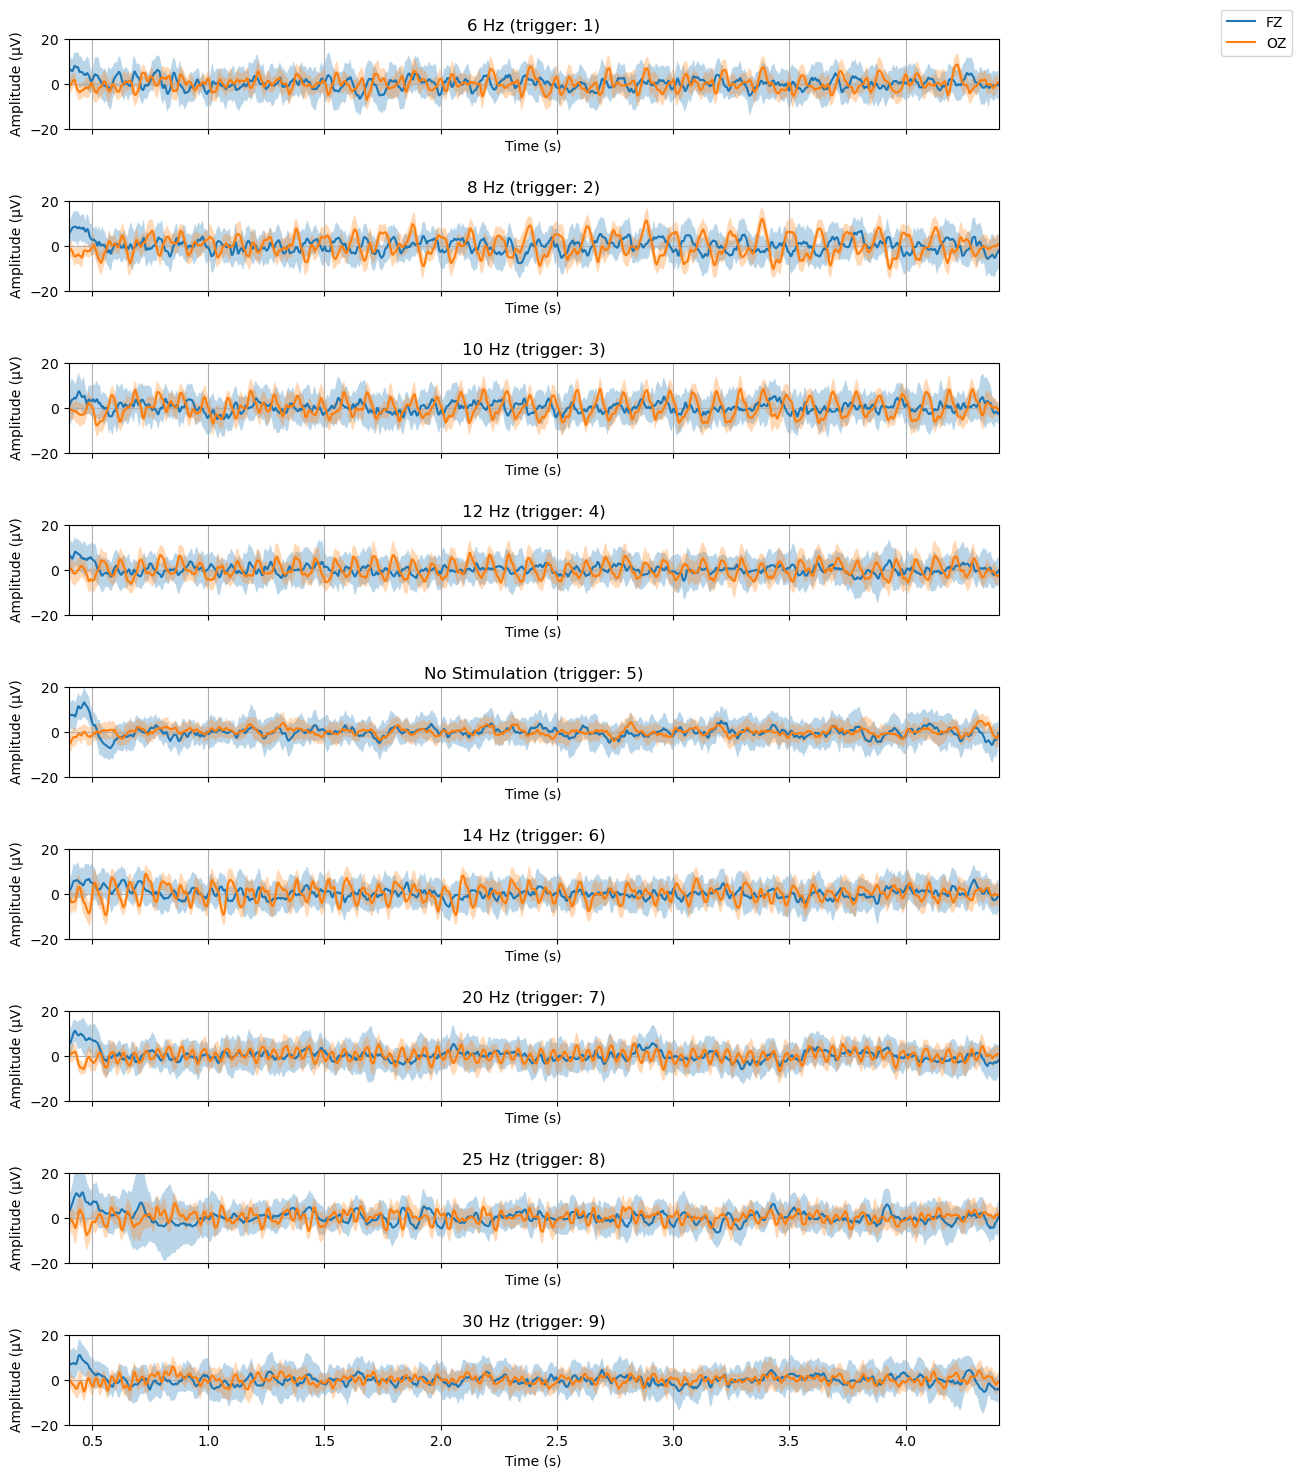

Valid event codes for spectral analysis: [1, 3, 4, 6, 7, 8, 9, 10, 11]


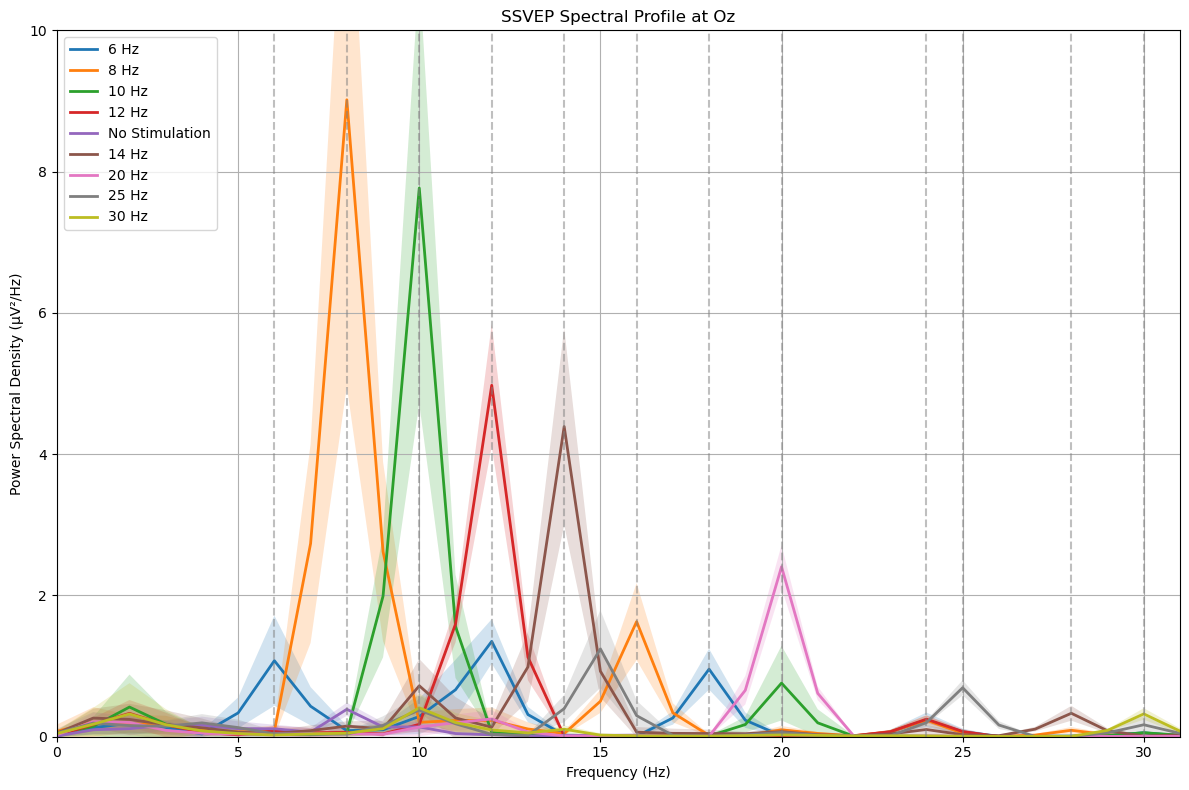

In [ ]:
def plot_temporal_profiles(epochs: mne.Epochs, event_labels: List[str], sorted_triggers: List[str],
                           channel_indices: Dict[str, int], time_window: List[float] = [0,4],
                           amplitude_range: List[float] = [-20,20]) -> None:
    """
    Plot the mean and standard deviation (temporal profiles) of specified EEG channels
    for each event type.
    
    Parameters:
    - epochs (mne.Epochs): The EEG epochs.
    - event_labels (List[str]): List of event labels in desired order.
    - sorted_triggers (List[str]): Sorted list of trigger keys (as strings).
    - channel_indices (Dict[str, int]): Mapping of channel names to their indices.
    - time_window (List[float], optional): Time window for x-axis (in seconds).
    - amplitude_range (List[float], optional): Amplitude range for y-axis (in µV).
    """
    n_events = len(event_labels)
    fig, axes = plt.subplots(nrows=n_events, ncols=1, figsize=(12, 2 * n_events), sharex=True)
    if n_events == 1:
        axes = [axes]
    plt.subplots_adjust(hspace=0.8)
    
    for idx, (label, trigger) in enumerate(zip(event_labels, sorted_triggers)):
        try:
            selected_epochs = epochs[str(trigger)]
        except Exception as e:
            print(f"Error selecting epochs for trigger {trigger}: {e}")
            continue
        
        # Convert the data to microvolts.
        data = selected_epochs.get_data() * 1e6
        ax = axes[idx]
        for ch_label, ch_idx in channel_indices.items():
            ch_mean = np.mean(data[:, ch_idx, :], axis=0)
            ch_std = np.std(data[:, ch_idx, :], axis=0)
            ax.plot(selected_epochs.times, ch_mean, label=ch_label)
            ax.fill_between(selected_epochs.times, ch_mean - ch_std, ch_mean + ch_std, alpha=0.3)
        ax.set(title=f"{label} (trigger: {trigger})", xlim=time_window, ylim=amplitude_range)
        ax.grid(True)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude (µV)')
    
    # Add a legend outside the subplots.
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 0.9))
    plt.show()


def perform_spectral_analysis(epochs: mne.Epochs, event_mapping: Dict[str, str],
                              channel: str, fs: int = 1000, window: str = 'hann',
                              nperseg: int = 1000, noverlap: int = 500, nfft: int = 1000,
                              valid_keys: List[str] = None) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Perform spectral analysis on the specified channel for each event type.
    
    Instead of using a hard-coded valid codes list, this function accepts an
    optional list of valid annotation keys (strings). It uses the event_id from
    the epochs to determine which events to analyze.
    """
    # If valid_keys is not provided, default to all keys in the event_mapping.
    if valid_keys is None:
        valid_keys = list(event_mapping.keys())
    # Build valid event codes from the epochs' event_id using the valid_keys.
    valid_codes = [epochs.event_id[k] for k in valid_keys if k in epochs.event_id]
    print("Valid event codes for spectral analysis:", valid_codes)
    
    channel_names = [name.upper() for name in epochs.info['ch_names']]
    try:
        channel_idx = channel_names.index(channel.upper())
    except ValueError:
        raise ValueError(f"Channel {channel} not found in data.")
    
    spectral_data = {}
    for trigger, label in event_mapping.items():
        if trigger not in epochs.event_id:
            print(f"Skipping trigger {trigger} (not found in epochs).")
            continue
        if epochs.event_id[trigger] not in valid_codes:
            print(f"Skipping trigger {trigger} because its event id ({epochs.event_id[trigger]}) is not in valid event codes {valid_codes}.")
            continue
        
        try:
            data = epochs[trigger].get_data() * 1e6  # Convert to µV
        except Exception as e:
            print(f"No epochs found for trigger {trigger}: {e}")
            continue
        
        # Average across trials for the specified channel.
        channel_data = data[:, channel_idx, :]  # shape: (n_trials, n_times)
        avg_time_series = np.mean(channel_data, axis=0)
        
        # Compute spectrogram.
        f, t, P = signal.spectrogram(avg_time_series, fs=fs, window=window,
                                     nperseg=nperseg, noverlap=noverlap,
                                     nfft=nfft, mode='psd')
        avgP = np.mean(P, axis=1)
        stdP = np.std(P, axis=1)
        
        spectral_data[label] = {
            'freqs': f,
            'avgP': avgP,
            'stdP': stdP
        }
    return spectral_data

def plot_spectral_profiles(spectral_data: Dict[str, Dict[str, np.ndarray]],
                           xlim: List[float] = [0, 31],
                           ylim: List[float] = [0, 10],
                           title: str = 'SSVEP Spectral Profile at Oz') -> None:
    """
    Plot the spectral profiles for each event type and add mode marks on the x-axis.
    """
    plt.figure(figsize=(12, 8))
    for label, data in spectral_data.items():
        freqs = data['freqs']
        avgP = data['avgP']
        stdP = data['stdP']
        plt.plot(freqs, avgP, linewidth=2, label=label)
        plt.fill_between(freqs, avgP - stdP, avgP + stdP, alpha=0.2)
    if xlim is not None:
        plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid(True)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (µV²/Hz)')
    plt.title(title)
    
    # Add vertical dashed lines ("mode marks") at expected stimulation frequencies and harmonics.
    mode_freqs = [6, 8, 10, 12, 14, 16, 18, 20, 24, 25, 28, 30]
    for mf in mode_freqs:
        plt.axvline(x=mf, color='gray', linestyle='--', alpha=0.5)
    
    plt.legend()
    plt.tight_layout()
    plt.show()


# =============================================================================
new_event_mapping = {
        '1': '6 Hz',
        '2': '8 Hz',
        '3': '10 Hz',
        '4': '12 Hz',
        '5': 'No Stimulation',
        '6': '14 Hz',
        '7': '20 Hz',
        '8': '25 Hz',
        '9': '30 Hz'
    }  

# event_labels = ['6 Hz', '8 Hz', '10 Hz', '12 Hz', 'No Stimulation', '14 Hz', '20 Hz', '25 Hz', '30 Hz']

print("Using event mapping:", new_event_mapping)


# Get channel indices for channels 'FZ' and 'OZ' (for temporal profile).
channels_to_plot_temp = ['FZ', 'OZ']
channel_indices_temp = get_channel_indices(epochs, channels_to_plot_temp)

# Plot the temporal profiles.
plot_temporal_profiles(epochs, new_event_mapping.values(), new_event_mapping, channel_indices_temp,
                       time_window=[0.4,4.4], amplitude_range=[-20,20])



spectral_data = perform_spectral_analysis(epochs, new_event_mapping, channel='OZ',
                                          fs=1000, window='hann',
                                          nperseg=1000, noverlap=500, nfft=1000)
plot_spectral_profiles(spectral_data)


## **Signal-to-Noise Ratio (SNR) Analysis for SSVEP Data**

### **Computing SNR for SSVEP Analysis**
To evaluate the strength of SSVEP responses, we compute the **Signal-to-Noise Ratio (SNR)** for each stimulation frequency. The process involves:
1. **Power Spectral Density (PSD) Calculation**: Using Welch's method to estimate the frequency components of the EEG signal.
2. **SNR Computation**: Measuring the ratio between signal power at a given frequency and the surrounding frequencies response (assumed to be noise) power.

### **Key Observations**
- **60 Hz Drop**: There is a **clear drop at 60 Hz**, which is expected due to **hardware notch filtering** performed during data recording.  
- **SNR Peaks at Stimulation Frequencies**: The **SNR is highest at the respective stimulation frequencies and their harmonics**, confirming the presence of strong periodic responses.  
- **Third Harmonic for 6 Hz**: Interestingly, for **6 Hz stimulation**, the highest SNR appears at the **third harmonic (18 Hz)** rather than at the fundamental frequency.  
- **Frequency Range Selection**:  
  - If we focus on **temporal features**, it is sufficient to analyze frequencies in the **6-30 Hz range** (first harmonic only).  
  - If we aim to capture additional harmonics, we can extend the range to **6-60 Hz** or even **6-80 Hz**.  
- **SNR Trends Across Channels**:  
  - **Higher SNR in occipital regions (Oz, O1, O2)** at stimulation frequencies.  
  - **For frequencies over 100 Hz, SNR is actually higher at Fz** than at occipital electrodes.  
  - **No useful information is observed above 80 Hz** for any stimulation condition.

### **Implications for Feature Extraction**
The findings from SNR analysis will guide the **feature selection strategy** for machine learning:
- If we focus on **low-frequency harmonics**, we limit feature extraction to **6-30 Hz**.
- If higher-order harmonics are informative, we consider extending the range to **31-80 Hz**.
- The **lack of meaningful information beyond 80 Hz** suggests that frequencies above this threshold can be discarded in classification tasks.

This step sets the stage for designing a robust **machine learning framework** based on the dominant SSVEP response frequencies.


Using event dictionary for SNR analysis: {'6 Hz': 1, '8 Hz': 3, '10 Hz': 4, '12 Hz': 6, 'No Stimulation': 7, '14 Hz': 8, '20 Hz': 9, '25 Hz': 10, '30 Hz': 11}


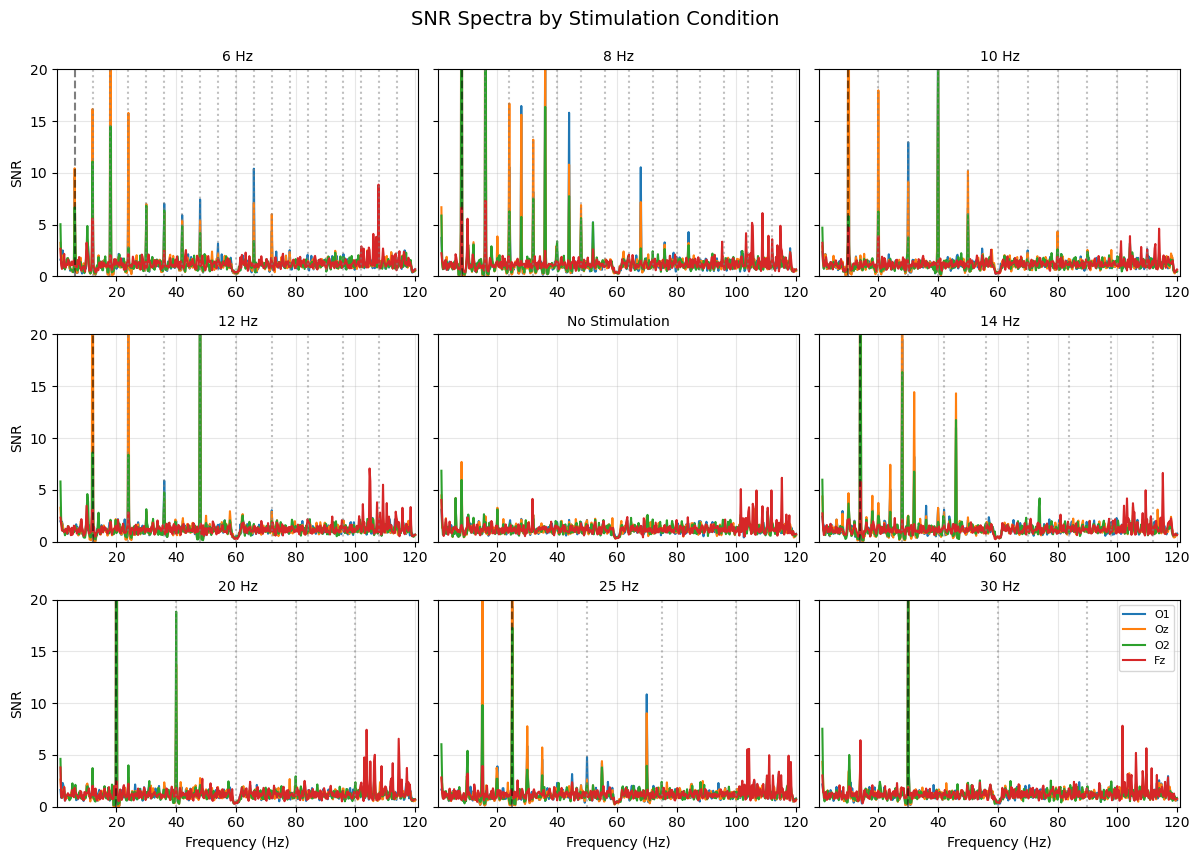

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy import signal
from typing import List, Dict
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def compute_psd_epochs(epochs: mne.Epochs, tmin: float, tmax: float,
                      fmin: float, fmax: float, fs: int = 1000,
                      window: str = 'boxcar'):
    """
    Compute Power Spectral Density (PSD) using Welch's method for the given epochs.
    
    Parameters:
    - epochs (mne.Epochs): The EEG epochs.
    - tmin (float): Start time for PSD computation.
    - tmax (float): End time for PSD computation.
    - fmin (float): Minimum frequency for PSD.
    - fmax (float): Maximum frequency for PSD.
    - fs (int, optional): Sampling frequency.
    - window (str, optional): Window type for Welch's method.
    
    Returns:
    - spectrum: The computed PSD object (an instance of mne.time_frequency.EpochsTFR).
    """
    spectrum = epochs.compute_psd(
        method='welch',
        n_fft=int(fs * (tmax - tmin)),
        n_overlap=0,
        n_per_seg=None,
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        window=window,
        verbose=False
    )
    return spectrum

def snr_spectrum(psd: np.ndarray, noise_n_neighbor_freqs: int = 3,
                 noise_skip_neighbor_freqs: int = 1) -> np.ndarray:
    """
    Compute Signal-to-Noise Ratio (SNR) spectrum with proper padding.
    
    Parameters:
    - psd (np.ndarray): Power Spectral Density data.
    - noise_n_neighbor_freqs (int, optional): Number of neighboring frequencies for noise.
    - noise_skip_neighbor_freqs (int, optional): Number of frequencies to skip.
    
    Returns:
    - snr (np.ndarray): Computed SNR spectrum.
    """
    n_neighbors = noise_n_neighbor_freqs
    n_skip = noise_skip_neighbor_freqs
    kernel = np.concatenate((np.ones(n_neighbors),
                             np.zeros(2 * n_skip + 1),
                             np.ones(n_neighbors)))
    kernel /= kernel.sum()
    mean_noise = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='valid'),
                                     axis=-1, arr=psd)
    edge_width = n_neighbors + n_skip
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width,
                        mode='constant', constant_values=np.nan)
    return psd / mean_noise

def plot_snr_spectra(epochs: mne.Epochs, spectrum, event_dict: Dict[str, str],
                     channels_of_interest: List[str], colors: List[str],
                     fmin: float, fmax: float, tmin: float, tmax: float) -> None:
    """
    Plot SNR spectra for each stimulation condition and specified channels.
    
    Parameters:
    - epochs (mne.Epochs): The EEG epochs.
    - spectrum: PSD results from compute_psd_epochs.
    - event_dict (Dict[str, str]): Mapping from event labels (e.g. '6 Hz') to event codes.
    - channels_of_interest (List[str]): List of channel names to analyze.
    - colors (List[str]): List of colors for plotting each channel.
    - fmin (float): Minimum frequency for plotting.
    - fmax (float): Maximum frequency for plotting.
    - tmin (float): Start time for epochs.
    - tmax (float): End time for epochs.
    """
    psds, freqs = spectrum.get_data(return_freqs=True)
    
    # Determine grid dimensions based on number of conditions.
    n_conditions = len(event_dict)
    ncols = int(np.ceil(np.sqrt(n_conditions)))
    nrows = int(np.ceil(n_conditions / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
    axes = np.array(axes).flatten()
    
    # Get channel indices (case-sensitive matching with epochs.ch_names)
    ch_indices = []
    for ch in channels_of_interest:
        try:
            idx = epochs.ch_names.index(ch)
            ch_indices.append(idx)
        except ValueError:
            print(f"Channel {ch} not found in data.")
            raise
    for ax_idx, (event_name, event_code) in enumerate(event_dict.items()):
        event_mask = epochs.events[:, 2] == event_code
        event_psds = psds[event_mask]
        
        snr_results = []
        for ch_idx in ch_indices:
            ch_psds = event_psds[:, ch_idx, :]
            ch_snr = snr_spectrum(ch_psds)
            snr_mean = np.nanmean(ch_snr, axis=0)
            snr_results.append(snr_mean)
        
        ax = axes[ax_idx]
        freq_mask = (freqs >= fmin) & (freqs <= fmax)
        plot_freqs = freqs[freq_mask]
        
        for color, ch_name, snr in zip(colors, channels_of_interest, snr_results):
            ax.plot(plot_freqs, snr[freq_mask], color=color, linewidth=1.5, label=ch_name)
        
        # Mark stimulation frequency and its harmonics (up to 19 (for 6 Hz) or 120 Hz)
        if 'Hz' in event_name:
            try:
                stim_freq = float(event_name.split()[0])
                for harmonic in range(1, 20):  # harmonics 1 to 19
                    harmonic_freq = stim_freq * harmonic
                    if harmonic_freq > 119:
                        break
                    if harmonic == 1:
                        ax.axvline(x=harmonic_freq, color='black', linestyle='--', alpha=0.5)
                    else:
                        ax.axvline(x=harmonic_freq, color='gray', linestyle=':', alpha=0.5)
            except Exception as e:
                print(f"Could not parse stimulation frequency from {event_name}: {e}")
        
        ax.set_title(f'{event_name}', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(fmin, fmax)
        ax.set_ylim(0, 20)
        if ax_idx >= ncols * (nrows - 1):
            ax.set_xlabel('Frequency (Hz)')
        if ax_idx % ncols == 0:
            ax.set_ylabel('SNR')
        else:
            ax.set_yticklabels([])
    
    # Add legend to the last subplot.
    axes[-1].legend(loc='upper right', fontsize=8)
    plt.suptitle('SNR Spectra by Stimulation Condition', y=0.95, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# =============================================================================
# Configuration for PSD and SNR
fmin, fmax = 0.1, 121
tmin, tmax = 0.4, epochs.tmax
fs = int(epochs.info['sfreq'])
window = 'boxcar'

# Compute PSD using Welch's method.
spectrum = compute_psd_epochs(epochs, tmin, tmax, fmin, fmax, fs=fs, window=window)

# For the event mapping, we derive a mapping from our current epochs.
new_event_mapping = {
    '1': '6 Hz',
    '2': '8 Hz',
    '3': '10 Hz',
    '4': '12 Hz',
    '5': 'No Stimulation',
    '6': '14 Hz',
    '7': '20 Hz',
    '8': '25 Hz',
    '9': '30 Hz'
}

# Invert new_event_mapping to get a mapping from event labels to event codes.
# (Assuming the keys in epochs.event_id match the keys in new_event_mapping.)
event_dict = {label: epochs.event_id[trigger] for trigger, label in new_event_mapping.items() if trigger in epochs.event_id}
print("Using event dictionary for SNR analysis:", event_dict)

# Define channels and colors for SNR plot.
channels_of_interest = ['O1', 'Oz', 'O2', 'Fz']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot the SNR spectra.
plot_snr_spectra(epochs, spectrum, event_dict, channels_of_interest, colors, fmin, fmax, tmin, tmax)


Used Annotations descriptions: ['1', '100', '2', '3', '36', '4', '5', '6', '7', '8', '9', '99']
Events extracted from annotations:
[[   6157       0      12]
 [  14675       0       3]
 [  22927       0       9]
 [  31263       0       4]
 [  39506       0       6]
 [  47829       0       1]
 [  56263       0      11]
 [  64694       0       7]
 [  72848       0       8]
 [  89327       0      11]
 [  97678       0       4]
 [ 105938       0       6]
 [ 114262       0       1]
 [ 122330       0      10]
 [ 130503       0       8]
 [ 138738       0       3]
 [ 147178       0       7]
 [ 155437       0       9]
 [ 163496       0      10]
 [ 171664       0       8]
 [ 179903       0       9]
 [ 188244       0       4]
 [ 196695       0      11]
 [ 205145       0       7]
 [ 213403       0       6]
 [ 221743       0       1]
 [ 230004       0       3]
 [ 238360       0       1]
 [ 246810       0      11]
 [ 255145       0       4]
 [ 263388       0       6]
 [ 271653       0       3]
 [ 27

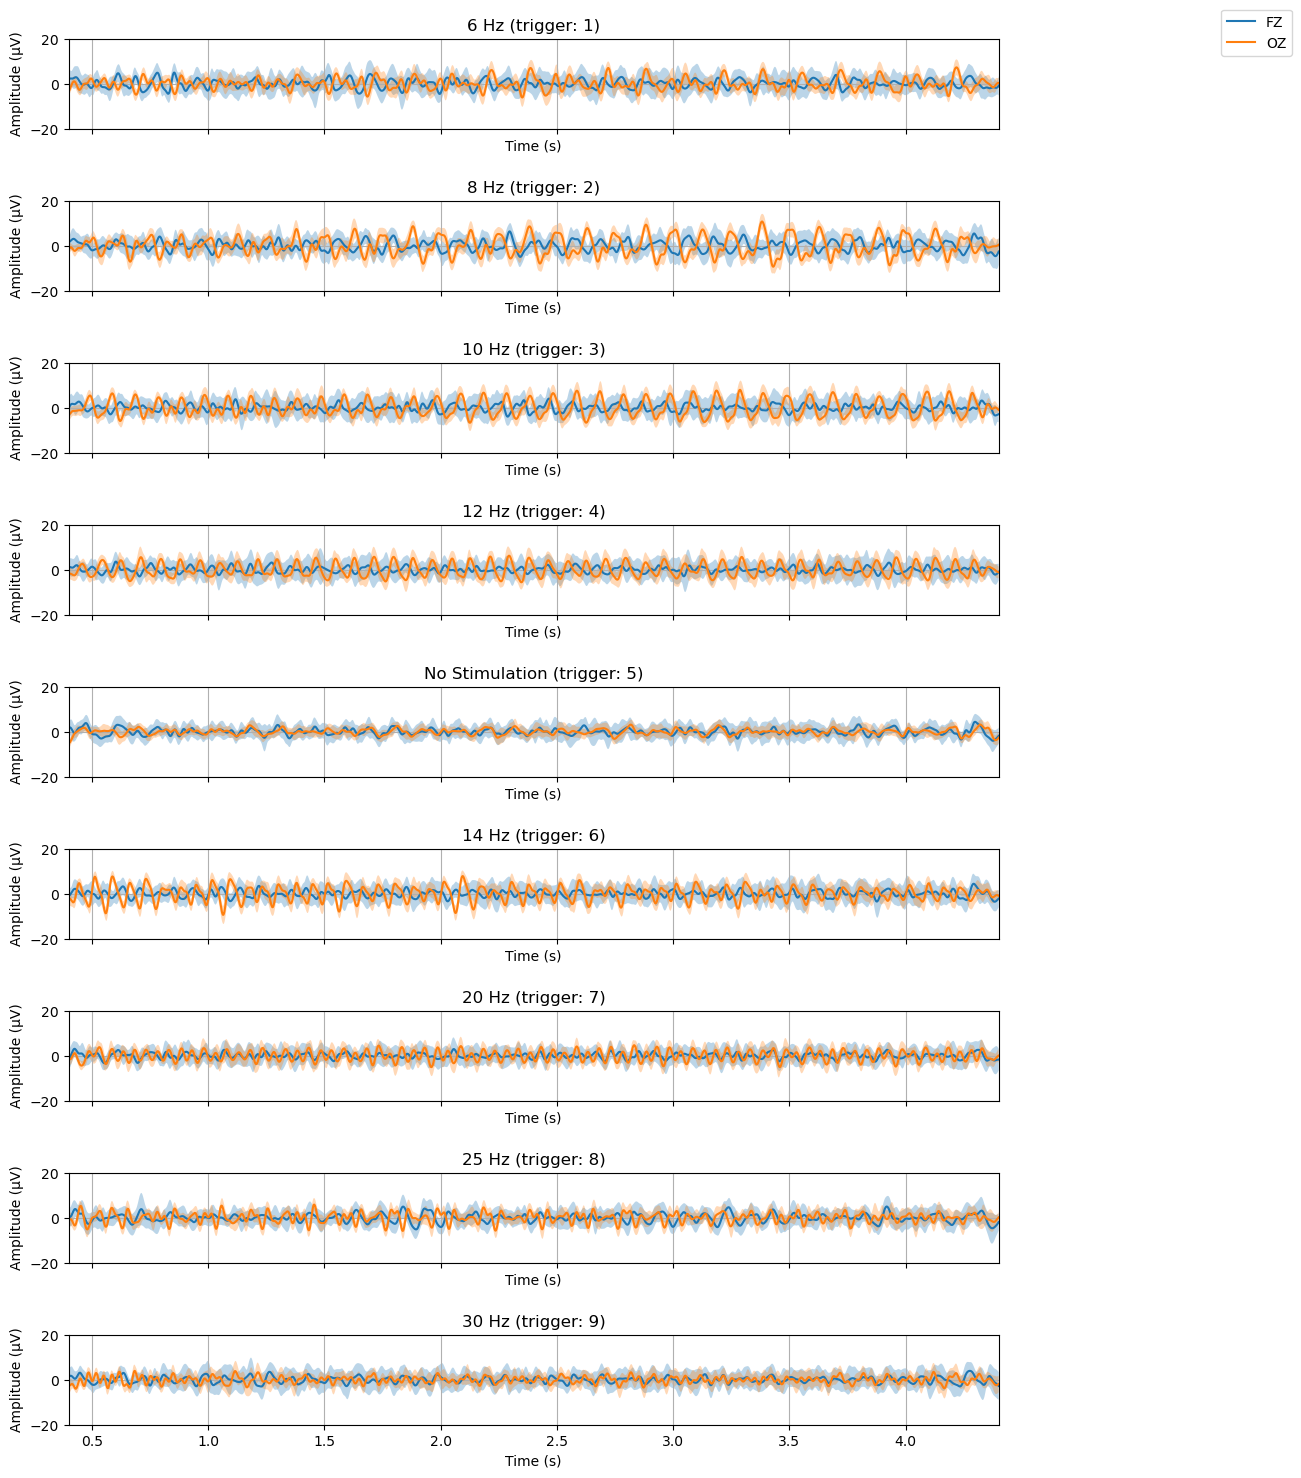

In [ ]:
def filter_raw_data(raw: mne.io.Raw, l_freq: float = None, h_freq: float = None) -> mne.io.Raw:
    """
    Filter the raw data using MNE's filtering function.
    
    Parameters:
    - raw (mne.io.Raw): The raw data to filter.
    - l_freq (float or None): The low cutoff frequency in Hz. For high-pass filtering, set to a value (e.g., 1.0).
                                For low-pass filtering, set to None.
    - h_freq (float or None): The high cutoff frequency in Hz. For low-pass filtering, set to a value (e.g., 40.0).
                                For high-pass filtering, set to None.
    
    Returns:
    - raw_filtered (mne.io.Raw): The filtered raw data.
    """
    raw_filtered = raw.copy().filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin', verbose=False)
    return raw_filtered


# =============================================================================
filtered_raw = filter_raw_data(raw_combined, l_freq=6.0, h_freq=30.0)

epochs_filtered = create_epochs_from_raw(filtered_raw, tmin=0.4, tmax=4.4)
print("Filtered epochs shape:", epochs_filtered.get_data().shape)

# Plot the temporal profiles.
plot_temporal_profiles(epochs_filtered, event_labels, new_event_mapping, channel_indices_temp,
                       time_window=[0.4,4.4], amplitude_range=[-20,20])
